In [21]:
import copy
import torch
from framework import utils
from framework.training_args import parse_args
from models.deletion import GCNDelete
from models.models import GCN
from trainers.base import Trainer
from attacks.edge_attack import edge_attack_random_nodes
from attacks.label_flip import label_flip_attack
import optuna
from optuna.samplers import TPESampler
from functools import partial


In [22]:
args = parse_args()
utils.seed_everything(args.random_seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train():
    # dataset
    print("==TRAINING==")
    clean_data= utils.get_original_data(args.dataset)
    utils.train_test_split(clean_data, args.random_seed, args.train_ratio)
    utils.prints_stats(clean_data)
    if "gnndelete" in args.unlearning_model:
        clean_model = GCNDelete(clean_data.num_features, args.hidden_dim, clean_data.num_classes)
    else:
        clean_model = GCN(clean_data.num_features, args.hidden_dim, clean_data.num_classes)

    optimizer = torch.optim.Adam(clean_model.parameters(), lr=0.01, weight_decay=5e-4)
    clean_trainer = Trainer(clean_model, clean_data, optimizer, args.training_epochs)
    clean_trainer.train()
    a_p, a_c = clean_trainer.subset_acc(3,2)
    print(f"Accuracy on poisoned classes: {a_p}")
    print(f"Accuracy on clean classes: {a_c}")  
    return clean_data, clean_model

def poison(clean_data):
    print("==POISONING==")
    if args.attack_type=="label":
        poisoned_data, poisoned_indices = label_flip_attack(clean_data, args.df_size, args.random_seed)
    elif args.attack_type=="edge":
        poisoned_data, poisoned_indices = edge_attack_random_nodes(clean_data, args.df_size, args.random_seed)
    elif args.attack_type=="random":
        poisoned_data = copy.deepcopy(clean_data)
        poisoned_indices = torch.randperm(clean_data.num_nodes)[:int(clean_data.num_nodes*args.df_size)]
    poisoned_data= poisoned_data.to(device)

    if "gnndelete" in args.unlearning_model:
        poisoned_model = GCNDelete(poisoned_data.num_features, args.hidden_dim, poisoned_data.num_classes)
    else:
        poisoned_model = GCN(poisoned_data.num_features, args.hidden_dim, poisoned_data.num_classes)
    
    optimizer = torch.optim.Adam(poisoned_model.parameters(), lr=0.01, weight_decay=5e-4)
    poisoned_trainer = Trainer(poisoned_model, poisoned_data, optimizer, args.training_epochs)
    poisoned_trainer.train()
    a_p, a_c = poisoned_trainer.subset_acc()
    print(f"Accuracy on poisoned classes: {a_p}")
    print(f"Accuracy on clean classes: {a_c}")
    return poisoned_data, poisoned_indices, poisoned_model

def unlearn(poisoned_data, poisoned_indices, poisoned_model):
    print("==UNLEARNING==")

    utils.find_masks(poisoned_data, poisoned_indices, attack_type=args.attack_type)
    unlearn_model = None
    if "gnndelete" in args.unlearning_model:
        unlearn_model = GCNDelete(poisoned_data.num_features, args.hidden_dim, poisoned_data.num_classes, mask_1hop=poisoned_data.sdf_node_1hop_mask, mask_2hop=poisoned_data.sdf_node_2hop_mask)
        
        # copy the weights from the poisoned model
        unlearn_model.load_state_dict(poisoned_model.state_dict())
        
        optimizer_unlearn= utils.get_optimizer(args, unlearn_model)
        unlearn_trainer= utils.get_trainer(args, unlearn_model, poisoned_data, optimizer_unlearn)
        unlearn_trainer.train()
    elif "retrain" in args.unlearning_model:
        unlearn_model = GCN(poisoned_data.num_features, args.hidden_dim, poisoned_data.num_classes)
        optimizer_unlearn= utils.get_optimizer(args, unlearn_model)
        unlearn_trainer= utils.get_trainer(args, unlearn_model, poisoned_data, optimizer_unlearn)
        unlearn_trainer.train()
    else:
        unlearn_model = GCN(poisoned_data.num_features, args.hidden_dim, poisoned_data.num_classes)
        unlearn_model.load_state_dict(poisoned_model.state_dict())
        optimizer_unlearn= utils.get_optimizer(args, unlearn_model)
        unlearn_trainer= utils.get_trainer(args, unlearn_model, poisoned_data, optimizer_unlearn)
        unlearn_trainer.train()
    a_p, a_c = unlearn_trainer.subset_acc()
    print(f"Accuracy on poisoned classes: {a_p}")
    print(f"Accuracy on clean classes: {a_c}")
        
    print("==UNLEARNING DONE==")
    return unlearn_model

In [23]:
clean_data, clean_model = train()
poisoned_data, poisoned_indices, poisoned_model = poison(clean_data)

==TRAINING==
Number of nodes:  2708
Number of edges:  10556
Number of features:  1433
Number of classes:  7
Number of training nodes:  2166
Number of testing nodes:  542


Epoch: 100%|██████████| 600/600 [00:03<00:00, 196.78it/s]


Train Acc: 0.8966789667896679, Misclassification: 0,  F1 Score: 0.8966789667896679
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.926829268292683, 0.9701492537313433] | Clean class acc: [0.7777777777777778, 0.8695652173913043, 0.9207920792079208, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.9484892610120131
Accuracy on clean classes: 0.861591055065776
==POISONING==
Poisoned 649 labels from class 3 and class 2


Epoch: 100%|██████████| 600/600 [00:02<00:00, 215.49it/s]

Train Acc: 0.6512915129151291, Misclassification: 0.5497835497835498,  F1 Score: 0.6512915129151291
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.5, 0.0] | Clean class acc: [0.7916666666666666, 0.8478260869565217, 0.9405940594059405, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.25
Accuracy on clean classes: 0.8639814027962013


In [24]:
args.unlearning_model="retrain"
args.unlearning_epochs=600
retrain_model = unlearn(poisoned_data, poisoned_indices, poisoned_model)

==UNLEARNING==
parameters_to_optimize ['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight']


Epoch: 100%|██████████| 600/600 [00:02<00:00, 224.05it/s]

Training Time: 2.681899070739746
Train Acc: 0.7509225092250923, Misclassification: 0.025974025974025976,  F1 Score: 0.7509225092250923
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.7682926829268293, 0.26865671641791045] | Clean class acc: [0.6944444444444444, 0.8913043478260869, 0.9306930693069307, 0.8360655737704918, 0.8709677419354839]
Accuracy on poisoned classes: 0.5184746996723699
Accuracy on clean classes: 0.8446950354566877
==UNLEARNING DONE==


In [25]:
args.unlearning_model="gnndelete"
args.unlearning_epochs=50
unlearn_model = unlearn(poisoned_data, poisoned_indices, poisoned_model)

==UNLEARNING==
parameters_to_optimize ['deletion1.deletion_weight', 'deletion2.deletion_weight']


Unlearning: 100%|██████████| 50/50 [00:00<00:00, 52.57it/s]

Train Acc: 0.7398523985239852, Misclassification: 0.23809523809523808,  F1 Score: 0.7398523985239852
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.8109756097560976, 0.0] | Clean class acc: [0.8333333333333334, 0.8260869565217391, 0.9306930693069307, 0.9508196721311475, 0.5806451612903226]
Accuracy on poisoned classes: 0.4054878048780488
Accuracy on clean classes: 0.8243156385166948
==UNLEARNING DONE==


In [26]:
args.unlearning_model="utu"
clean_data, clean_model = train()
poisoned_data, poisoned_indices, poisoned_model = poison(clean_data)
args.unlearning_epochs=1
unlearn_model_utu = unlearn(poisoned_data, poisoned_indices, poisoned_model)

==TRAINING==
Number of nodes:  2708
Number of edges:  10556
Number of features:  1433
Number of classes:  7
Number of training nodes:  2166
Number of testing nodes:  542


Epoch: 100%|██████████| 600/600 [00:02<00:00, 205.84it/s]


Train Acc: 0.8966789667896679, Misclassification: 0,  F1 Score: 0.8966789667896679
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.926829268292683, 0.9701492537313433] | Clean class acc: [0.7777777777777778, 0.8695652173913043, 0.9207920792079208, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.9484892610120131
Accuracy on clean classes: 0.861591055065776
==POISONING==
Poisoned 649 labels from class 3 and class 2


Epoch: 100%|██████████| 600/600 [00:02<00:00, 200.49it/s]


Train Acc: 0.6568265682656826, Misclassification: 0.5367965367965368,  F1 Score: 0.6568265682656826
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.5182926829268293, 0.0] | Clean class acc: [0.7916666666666666, 0.8478260869565217, 0.9405940594059405, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.25914634146341464
Accuracy on clean classes: 0.8639814027962013
==UNLEARNING==
parameters_to_optimize ['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight']
Train Acc: 0.6678966789667896, Misclassification: 0.45454545454545453,  F1 Score: 0.6678966789667896
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.5548780487804879, 0.029850746268656716] | Clean class acc: [0.8194444444444444, 0.8478260869565217, 0.9207920792079208, 0.8360655737704918, 0.8709677419354839]
Accuracy on poisoned classes: 0.2923643975245723
Accuracy on clean classes: 0.8590191852629726
==UNLEARNING DONE==


In [27]:
args.unlearning_model="contrastive"
clean_data, clean_model = train()
poisoned_data, poisoned_indices, poisoned_model = poison(clean_data)
args.unlearning_epochs=1
unlearn_model_contrastive = unlearn(poisoned_data, poisoned_indices, poisoned_model)

==TRAINING==
Number of nodes:  2708
Number of edges:  10556
Number of features:  1433
Number of classes:  7
Number of training nodes:  2166
Number of testing nodes:  542


Epoch: 100%|██████████| 600/600 [00:02<00:00, 207.29it/s]


Train Acc: 0.8966789667896679, Misclassification: 0,  F1 Score: 0.8966789667896679
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.926829268292683, 0.9701492537313433] | Clean class acc: [0.7777777777777778, 0.8695652173913043, 0.9207920792079208, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.9484892610120131
Accuracy on clean classes: 0.861591055065776
==POISONING==
Poisoned 649 labels from class 3 and class 2


Epoch: 100%|██████████| 600/600 [00:03<00:00, 194.90it/s]


Train Acc: 0.6605166051660517, Misclassification: 0.5281385281385281,  F1 Score: 0.6605166051660517
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.5304878048780488, 0.0] | Clean class acc: [0.7916666666666666, 0.8478260869565217, 0.9405940594059405, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.2652439024390244
Accuracy on clean classes: 0.8639814027962013
==UNLEARNING==
parameters_to_optimize ['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight']


Unlearning 2: 100%|██████████| 10/10 [00:00<00:00, 238.89it/s]

Train Acc: 0.8081180811808119, Misclassification: 0.03463203463203463,  F1 Score: 0.8081180811808119
Training time: 21.90123414993286
Poisoned class: 3 -> 2 | Clean classes: [0, 1, 4, 5, 6]
Poisoned class acc: [0.7865853658536586, 0.5522388059701493] | Clean class acc: [0.7638888888888888, 0.9130434782608695, 0.9405940594059405, 0.8688524590163934, 0.8709677419354839]
Accuracy on poisoned classes: 0.6694120859119039
Accuracy on clean classes: 0.8714693255015152
==UNLEARNING DONE==


In [53]:
import torch.nn.functional as F

# compare p_retrain - p_unlearn for retain mask and plot density of nodes against change in prediction probability
diffs = []
retain_embs = F.softmax(clean_model(clean_data.x, clean_data.edge_index), dim=1)

unlearn_embs = F.softmax(unlearn_model(poisoned_data.x, poisoned_data.edge_index[:,poisoned_data.dr_mask]), dim=1)

diffs_2 = []
unlearn_embs_utu = F.softmax(unlearn_model_utu(poisoned_data.x, poisoned_data.edge_index[:,poisoned_data.dr_mask]), dim=1)

diffs_3 = []
unlearn_embs_contrastive = F.softmax(unlearn_model_contrastive(poisoned_data.x, poisoned_data.edge_index[:,poisoned_data.dr_mask]), dim=1)

for i in range(len(retain_embs)):
    if poisoned_data.test_mask[i] == 0:
        continue
    if poisoned_data.y[i] == poisoned_data.class1 or poisoned_data.y[i] == poisoned_data.class2:
        # continue
        diff = retain_embs[i] - unlearn_embs[i]
        diffs.append(diff)
        
        diff_2 = retain_embs[i] - unlearn_embs_utu[i]
        diffs_2.append(diff_2)
        
        diff_3 = retain_embs[i] - unlearn_embs_contrastive[i]
        diffs_3.append(diff_3)
    
print("Number of nodes: ", len(diffs))
    
diffs = torch.stack(diffs).cpu().detach().numpy()
diffs_2 = torch.stack(diffs_2).cpu().detach().numpy()
diffs_3 = torch.stack(diffs_3).cpu().detach().numpy()

# normalize the differences to a gaussian with mean 0 and std 1 for each class
diffs = (diffs - diffs.mean(axis=0)) / diffs.std(axis=0)
diffs_2 = (diffs_2 - diffs_2.mean(axis=0)) / diffs_2.std(axis=0)
diffs_3 = (diffs_3 - diffs_3.mean(axis=0)) / diffs_3.std(axis=0)

# take mean across all classes
diffs = diffs.mean(axis=1)
diffs_2 = diffs_2.mean(axis=1)
diffs_3 = diffs_3.mean(axis=1)

print(diffs.shape)
print(diffs_2.shape)
print(diffs_3.shape)

Number of nodes:  231
(231,)
(231,)
(231,)


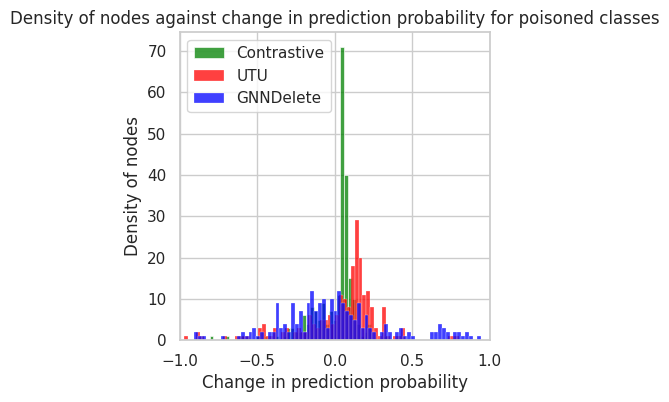

In [55]:

# plot a histogram of the differences with seaborn
import seaborn as sns
import matplotlib.pyplot as plt


# make the plot beautiful
sns.set(style="whitegrid")
plt.figure(figsize=(4,4))
sns.histplot(diffs_3, color="green", label="Contrastive", binwidth=0.025)
sns.histplot(diffs_2, color="red", label="UTU", binwidth=0.025)
sns.histplot(diffs, color="blue", label="GNNDelete", binwidth=0.025)
plt.title("Density of nodes against change in prediction probability for poisoned classes")
plt.xlabel("Change in prediction probability")
plt.ylabel("Density of nodes")
# clip the x-axis to -2, 2

plt.xlim(-1, 1)
plt.legend()
plt.show()


In [42]:
import numpy as np
from scipy.stats import ttest_rel

# Assuming you have your arrays contrastive and utu
# Example arrays:
contrastive = np.array(diffs_3)
utu = np.array(diffs_2)

# Take the absolute values
abs_contrastive = np.abs(contrastive)
abs_utu = np.abs(utu)

# Perform a paired t-test
t_statistic, p_value = ttest_rel(abs_contrastive, abs_utu, alternative='less')

print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The mean of absolute contrastive values is significantly lower than that of UTU.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the means of absolute contrastive and UTU values.")


t-statistic: -0.8013807093977614
p-value: 0.21176254631026953
Fail to reject the null hypothesis: No significant difference between the means of absolute contrastive and UTU values.


Number of nodes:  1518


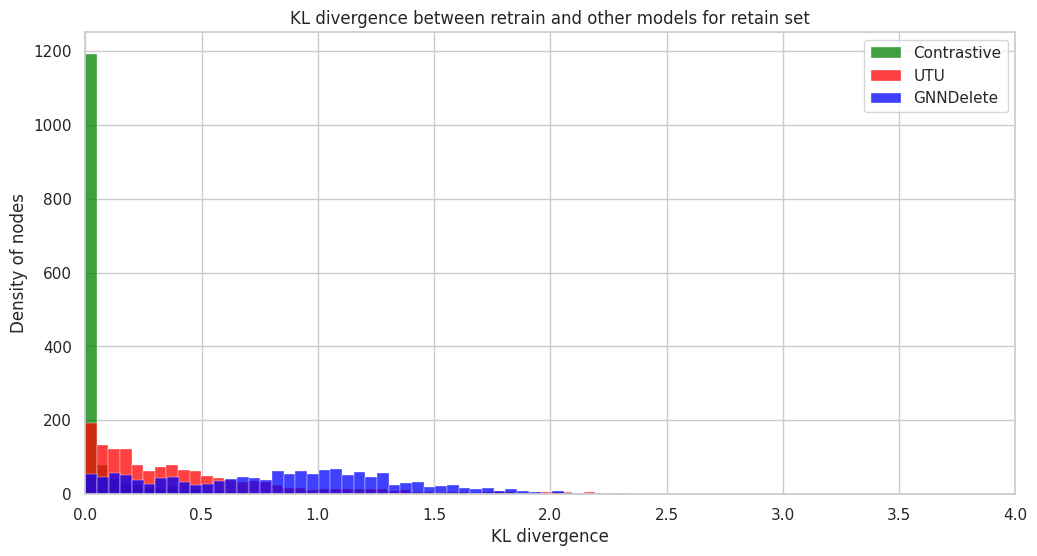

In [30]:
# calc kl divergence between retrain and other models and plot histogram
from torch.distributions import kl_divergence

kl_divs = []
kl_divs_2 = []
kl_divs_3 = []

for i in range(len(retain_embs)):
    if poisoned_data.train_mask[i] == 0:
        continue
    kl_div = kl_divergence(torch.distributions.Categorical(probs=retain_embs[i]), torch.distributions.Categorical(probs=unlearn_embs[i]))
    kl_divs.append(kl_div)
    
    kl_div_2 = kl_divergence(torch.distributions.Categorical(probs=retain_embs[i]), torch.distributions.Categorical(probs=unlearn_embs_utu[i]))
    kl_divs_2.append(kl_div_2)
    
    kl_div_3 = kl_divergence(torch.distributions.Categorical(probs=retain_embs[i]), torch.distributions.Categorical(probs=unlearn_embs_contrastive[i]))
    kl_divs_3.append(kl_div_3)
    
print("Number of nodes: ", len(kl_divs))

kl_divs = torch.stack(kl_divs).cpu().detach().numpy()

kl_divs_2 = torch.stack(kl_divs_2).cpu().detach().numpy()

kl_divs_3 = torch.stack(kl_divs_3).cpu().detach().numpy()


# plot  
plt.figure(figsize=(12, 6))
sns.histplot(kl_divs_3, color="green", label="Contrastive", binwidth=0.05)
sns.histplot(kl_divs_2, color="red", label="UTU", binwidth=0.05)
sns.histplot(kl_divs, color="blue", label="GNNDelete", binwidth=0.05)
plt.title("KL divergence between retrain and other models for retain set")
plt.xlabel("KL divergence")
plt.ylabel("Density of nodes")
plt.xlim(0, 4)
plt.legend()
plt.show()
